In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!pip install nilearn

     |████████████████████████████████| 2.5MB 2.8MB/s 


In [0]:
from IPython.core import display as ICD
import pandas as pd
import glob, os
import seaborn as sns
import nilearn
from sklearn import svm
import numpy as np
from sklearn.model_selection import GridSearchCV, cross_val_score


In [0]:
# first we need to load the data file into a data frame 

multisite_df = pd.read_csv('drive/My Drive/Projects/pilot_mouse_connectivity/cocaine_two_mice/Spectrogram_data/updated_data/multisite_averaged_data.csv')

In [65]:
multisite_df.drop("Unnamed: 0", axis=1,inplace=True)
multisite_df.head()

,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
0,-56.501194,-58.404691,-53.796707,-54.683450,-50.765295,-49.201600,-47.156084,-47.257051,-37.099407,-37.333310,-35.815629,-36.039001,31.250000,1,0,0.461047,post,1
1,-55.990462,-58.988152,-54.108313,-53.480236,-49.899241,-49.516848,-45.858436,-48.210181,-40.991329,-42.757552,-36.514741,-38.500080,-40.040267,1,1,0.482850,post,1
2,-56.533964,-56.703969,-53.713006,-53.388769,-47.988294,-47.911166,-45.839712,-44.819948,-36.329574,-36.786060,-34.261496,-38.705199,-46.110695,1,2,0.490247,post,1
3,-55.088293,-57.277582,-54.759970,-53.832872,-49.272411,-47.161322,-46.172072,-46.595272,-37.772853,-33.544189,-36.755222,-39.528779,-41.637959,1,3,0.485528,post,1
4,-56.064453,-56.391981,-54.370658,-54.151737,-48.075181,-44.963544,-47.350350,-44.067891,-41.780323,-37.090223,-37.366601,-36.990245,-39.613447,1,4,0.494177,post,1


In [0]:
#multisite_df.columns.values

In [0]:
# turn cocaine category labels into numerics, 0: post and 1: pre
multisite_df['cocaine status'] = pd.factorize(multisite_df['cocaine status'])[0]


In [0]:
multisite_df.fillna(multisite_df.mean(), inplace=True)

In [69]:
multisite_df.tail()

,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
14395,-57.945512,-60.610124,-54.832686,-54.930917,-53.453498,-54.694912,-48.215670,-54.100591,-45.402066,-43.293175,-41.552947,-44.923270,-56.379793,1,1795,1.145819,1,2
14396,-57.283914,-61.857844,-53.046077,-56.369021,-53.506348,-52.885991,-44.472734,-46.909043,-36.616661,-43.950709,-33.409286,-38.811592,-56.379793,1,1796,0.167269,1,2
14397,-57.621165,-62.037227,-54.470172,-56.285570,-50.645157,-48.306280,-46.802928,-46.783425,-46.357364,-41.330419,-36.800070,-37.888468,-56.379793,1,1797,0.155295,1,2
14398,-59.532244,-61.890011,-54.634515,-54.805142,-51.794797,-54.021217,-47.390373,-51.180051,-48.041564,-42.124833,-35.664824,-40.147725,-56.379793,1,1798,0.004777,1,2
14399,-58.429392,-62.086589,-54.455730,-56.122061,-47.567010,-49.108323,-46.107437,-52.037337,-41.694312,-42.653839,-33.130993,-40.041810,-56.379793,1,1799,0.000000,1,2


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma',
       'PFC beta', 'VTA beta', 'BLA beta', 'NAc beta', 'PFC theta',
       'VTA theta', 'BLA theta', 'NAc theta', 'reference wires']] = scaler.fit_transform(multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma',
                                                                                                       'PFC beta', 'VTA beta', 'BLA beta', 'NAc beta', 'PFC theta',
                                                                                                       'VTA theta', 'BLA theta', 'NAc theta', 'reference wires']])

In [71]:
multisite_df.tail()

,PFC gamma,VTA gamma,BLA gamma,NAc gamma,PFC beta,VTA beta,BLA beta,NAc beta,PFC theta,VTA theta,BLA theta,NAc theta,reference wires,mouse id,Time (s),Speed (cm/s),cocaine status,recording
14395,0.160803,0.098663,0.379112,0.435232,0.116256,0.096596,0.365786,0.217770,0.279710,0.291921,0.411115,0.285573,0.274108,1,1795,1.145819,1,2
14396,0.181986,0.068729,0.430632,0.385932,0.114759,0.148119,0.458901,0.440185,0.478738,0.274591,0.601804,0.449501,0.274108,1,1796,0.167269,1,2
14397,0.171188,0.064426,0.389566,0.388793,0.195808,0.278560,0.400931,0.444070,0.258068,0.343653,0.522407,0.474261,0.274108,1,1797,0.155295,1,2
14398,0.109998,0.067958,0.384827,0.439544,0.163242,0.115785,0.386317,0.308095,0.219913,0.322715,0.548989,0.413663,0.274108,1,1798,0.004777,1,2
14399,0.145310,0.063242,0.389982,0.394398,0.283002,0.255716,0.418233,0.281581,0.363707,0.308772,0.608321,0.416504,0.274108,1,1799,0.000000,1,2


## Decoding cocaine status based on gamma  


In [0]:
# prepare data for decoding
# pull out gamma columns  
X=multisite_df[['PFC gamma', 'VTA gamma', 'BLA gamma', 'NAc gamma',
     'reference wires', 'mouse id', 'Time (s)', 'Speed (cm/s)','cocaine status']].to_numpy()

In [73]:
X.shape

(14400, 8)

In [0]:
y=multisite_df['cocaine status']

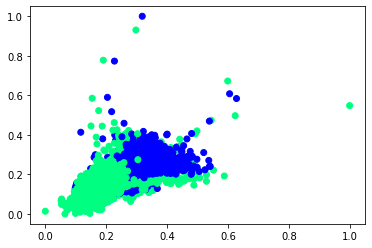

In [96]:
from matplotlib import pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')


In [92]:
X[:, 0],X[:, 1]

(array([0.20704802, 0.22340096, 0.20599879, ..., 0.17118811, 0.10999802,
        0.14530979]),
 array([0.15157223, 0.13757469, 0.19237344, ..., 0.06442577, 0.06795756,
        0.06324156]))

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [99]:
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_pred=clf.predict(X_train)

In [101]:
y_pred[0:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1])

In [102]:
from sklearn.model_selection import GridSearchCV, cross_val_score
# We are going to tune the parameter 'k' of the step called 'anova' in
# the pipeline. Thus we need to address it as 'svc__k'.
k_range = [10, 15, 30, 50, 150, 300, 500, 1000, 1500, 3000, 5000]


grid = GridSearchCV(clf, param_grid={'C': k_range}, verbose=1, n_jobs=4)
nested_cv_scores = cross_val_score(grid, X_test, y_test, cv=5)
print("Nested CV score: %.4f" % np.mean(nested_cv_scores))


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   14.2s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   11.8s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   11.4s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.4s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   11.5s finished


Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done  55 out of  55 | elapsed:   12.5s finished


Nested CV score: 0.8422


In [104]:
from mlxtend.plotting import plot_decision_regions

# Plot Decision Region using mlxtend's awesome plotting function
plot_decision_regions(X=X_test.values, 
                      y=y_test.values,
                      clf=clf, 
                      legend=2)

# Update plot object with X/Y axis labels and Figure Title
plt.xlabel(X_test.columns[0], size=14)
plt.ylabel(X_test.columns[1], size=14)
plt.title('SVM Decision Region Boundary', size=16)

AttributeError: ignored